In [1]:
import torch
import sys
import os
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import ceil
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import AdamW
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
from IPython.display import clear_output
import os
from torchvision.ops import StochasticDepth


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [ ]:
os.cpu_count()

In [ ]:
print(sys.executable)  # Путь должен указывать venv

In [3]:
class MoleDataset(Dataset):
    def __init__(self, csv_file: str, img_dir: str, 
                 img_size: int = 256,
                 transform: transforms.Compose = None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.img_size = img_size

        self.base_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std =[0.229, 0.224, 0.225]),
        ])

        if transform:
            self.transform = transforms.Compose([
                *self.base_transform.transforms,
                *transform.transforms
            ])
        else:
            self.transform = self.base_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        img_id = row['isic_id']
        target = row['benign_malignant']

        for ext in ('jpg', 'png', 'jpeg'):
            img_path = os.path.join(self.img_dir, f"{img_id}.{ext}")
            if os.path.exists(img_path):
                break
        else:
            raise FileNotFoundError(f"Не найден файл для {img_id} в {self.img_dir}")

        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)

        target_tensor = torch.tensor(target, dtype=torch.long)

        return image, target_tensor


In [4]:
BATCH_SIZE = 32

img_size = 256

train_ds = MoleDataset(
    csv_file='dataset/train_augmented.csv',
    img_dir='dataset/img_train', 
    img_size=img_size
)

val_ds = MoleDataset(
    csv_file='dataset/val_split.csv', 
    img_dir='dataset/img_val', 
    img_size=img_size
)

train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [ ]:
class SkinCancerCNN(nn.Sequential):
    def __init__(self):
        super().__init__(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  
            
            nn.AdaptiveAvgPool2d(1),  
            nn.Flatten(),
            nn.Linear(256, 128), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )
model = SkinCancerCNN().to(device)

In [ ]:
class LayerNorm2d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim, eps=1e-6)

    def forward(self, x):
        return self.norm(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

class ConvNeXtBlock(nn.Module):
    def __init__(self, dim, drop_path_rate=0.25):
        super().__init__()

        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = LayerNorm2d(dim)
        

        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)

        self.drop_path = StochasticDepth(drop_path_rate, mode="row")
        self.dropout = nn.Dropout2d(0.7)

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = self.norm(x)
        
        x = x.permute(0, 2, 3, 1)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.dropout(x) 
        x = self.pwconv2(x)
        
        x = x.permute(0, 3, 1, 2) 
        
        return input + self.drop_path(x)

class ConvNeXt(nn.Module):
    def __init__(self, num_classes=1, dims=[64, 128, 256, 512], depths=[3, 3, 9, 3]):
        super().__init__()
        
        self.stem = nn.Sequential(
            nn.Conv2d(3, dims[0], kernel_size=4, stride=4),
            LayerNorm2d(dims[0])
        )
        
        self.stages = nn.ModuleList()
        for i in range(4):
            stage = nn.Sequential(
                *[ConvNeXtBlock(dims[i]) for _ in range(depths[i])],
                self._make_downsample(i, dims)  
            )
            self.stages.append(stage)
        
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LayerNorm(dims[-1]),
            nn.Linear(dims[-1], num_classes) 
        )

    def _make_downsample(self, stage_idx, dims):
        if stage_idx < 3:
            return nn.Sequential(
                LayerNorm2d(dims[stage_idx]),
                nn.Conv2d(dims[stage_idx], dims[stage_idx+1], kernel_size=2, stride=2)
            )
        return nn.Identity()

    def forward(self, x):
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)
        return self.head(x)

    def forward(self, x):
        x = self.stem(x) 
        
        for stage in self.stages:
            x = stage(x)  
        
        return self.head(x)  

model = ConvNeXt().to(device)
# Проверка, должны выдать [2, 1]
x = torch.randn(2, 3, 256, 256).to(device)
print(model(x).shape)  

torch.Size([2, 1])


In [6]:
def show_metrics(epoch: int, **samples) -> None:
    clear_output(wait=True)

    plt.figure(figsize=(18, 10))
    charts = len(samples)

    for i, sample in enumerate(samples):
        plt.subplot(ceil(charts / 3), 3, i + 1)
        plt.title(sample)
        plt.yscale('log' if sample == 'Loss' else 'linear')
        for metric_name, metric_vals in samples[sample].items():
            plt.plot(range(len(metric_vals)), metric_vals, label=metric_name)
        plt.legend()
    plt.show()

    print(f"\nEpoch {epoch} summary:")
    for name, grp in samples.items():
        tr_last = grp['train'][-1]
        val_last = grp['val'][-1]
        print(f"{name:<9} | train: {tr_last:>.4f} | val: {val_last:>.4f}")

In [ ]:
class TrainingPipeline:
    def __init__(self, model: nn.Module, train_loader: DataLoader,
                 val_loader: DataLoader, criterion: nn.Module,
                 optimizer: optim.Optimizer, device: torch.device,
                 scheduler=None,
                 metrics_visualizer=show_metrics,
                 scheduler_step_per_epoch: bool = True,
                 checkpoint_dir=None,
                 metric_average: str = 'macro',
                 grad_accum_steps: int = 1,
                 use_amp: bool = True,
                 early_stopping_patience: int = None, 
                 early_stopping_min_delta: float = 0.0): 
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.scheduler = scheduler
        self.metrics_visualizer = metrics_visualizer
        self.scheduler_step_per_epoch = scheduler_step_per_epoch
        self.checkpoint_dir = checkpoint_dir
        self.metric_average = metric_average
        self.grad_accum_steps = grad_accum_steps
        self.use_amp = use_amp
        self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_min_delta = early_stopping_min_delta
        self.best_val_loss = float('inf')
        self.epochs_without_improvement = 0

        if self.checkpoint_dir:
            os.makedirs(self.checkpoint_dir, exist_ok=True)

        self.metrics = {
            'Loss': {'train': [], 'val': []},
            'Accuracy': {'train': [], 'val': []},
            'Precision': {'train': [], 'val': []},
            'Recall': {'train': [], 'val': []},
            'F1': {'train': [], 'val': []}
        }

    def _check_early_stopping(self, val_loss: float) -> bool:
        """Проверяет, нужно ли остановить обучение."""
        if self.early_stopping_patience is None:
            return False
            
        improved = (self.best_val_loss - val_loss) > self.early_stopping_min_delta
        
        if improved:
            self.best_val_loss = val_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1
            if self.epochs_without_improvement >= self.early_stopping_patience:
                print(f"\nEarly stopping triggered! No improvement for {self.early_stopping_patience} epochs.")
                return True
        return False

    def _calculate_metrics(self, all_outputs: torch.Tensor, all_labels: torch.Tensor):
        if all_labels.numel() == 0:
            return {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
        
        predicted = (torch.sigmoid(all_outputs) > 0.5).long()
        if len(all_outputs.shape) > 1 and all_outputs.shape[1] == 1:
            predicted = predicted.squeeze(1)
        
        labels_np = all_labels.cpu().numpy()
        predicted_np = predicted.cpu().numpy()
        
        accuracy = (predicted == all_labels).float().mean().item()
        precision = precision_score(labels_np, predicted_np, average='binary', zero_division=0)
        recall = recall_score(labels_np, predicted_np, average='binary', zero_division=0)
        f1 = f1_score(labels_np, predicted_np, average='binary', zero_division=0)
        
        return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

    def _run_epoch(self, phase: str):
        is_train = phase == 'train'
        if is_train:
            self.model.train()
            loader = self.train_loader
        else:
            self.model.eval()
            loader = self.val_loader

        running_loss = 0.0
        all_labels_list = []
        all_outputs_list = []
        processed_samples = 0
        counter = 0

        context = torch.enable_grad() if is_train else torch.no_grad()
        with context:
            for batch_idx, (inputs, labels) in enumerate(tqdm(loader)):
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                with torch.amp.autocast(device_type='cuda', enabled=self.use_amp and is_train):
                    outputs = self.model(inputs).squeeze(1)
                    loss = self.criterion(outputs, labels.float())
                    
                    if is_train:
                        loss = loss / self.grad_accum_steps

                if is_train:
                    self.scaler.scale(loss).backward()

                    if (batch_idx + 1) % self.grad_accum_steps == 0 or (batch_idx + 1) == len(loader):
                        self.scaler.step(self.optimizer)
                        self.scaler.update()
                        self.optimizer.zero_grad()

                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size * (self.grad_accum_steps if is_train else 1)
                processed_samples += batch_size

                all_outputs_list.append(outputs.detach().cpu())
                all_labels_list.append(labels.detach().cpu())

        all_outputs_tensor = torch.cat(all_outputs_list, dim=0) if all_outputs_list else torch.empty(0)
        all_labels_tensor = torch.cat(all_labels_list, dim=0) if all_labels_list else torch.empty(0)

        epoch_loss = running_loss / processed_samples if processed_samples > 0 else 0.0
        epoch_metrics = self._calculate_metrics(all_outputs_tensor, all_labels_tensor)

        return {'loss': epoch_loss, **epoch_metrics}

    def _save_checkpoint(self, epoch: int, val_loss: float):
        if not self.checkpoint_dir:
            return

        checkpoint_path = os.path.join(self.checkpoint_dir, f'model_epoch_{epoch}.pth')
        state = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
            'scaler_state_dict': self.scaler.state_dict() if self.use_amp else None,
        }
        if self.scheduler:
            state['scheduler_state_dict'] = self.scheduler.state_dict()

        torch.save(state, checkpoint_path)

    def run_training(self, num_epochs: int):
            for epoch in range(1, num_epochs + 1):
                train_res = self._run_epoch('train')
                val_res = self._run_epoch('val')

                # Сохранение метрик
                for k, alias in (('loss', 'Loss'),
                                ('accuracy', 'Accuracy'),
                                ('precision', 'Precision'),
                                ('recall', 'Recall'),
                                ('f1', 'F1')):
                    self.metrics[alias]['train'].append(train_res[k])
                    self.metrics[alias]['val'].append(val_res[k])

                # Проверка ранней остановки
                if self._check_early_stopping(val_res['loss']):
                    break  

                if self.scheduler:
                    if self.scheduler_step_per_epoch and not isinstance(
                            self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                        self.scheduler.step()
                    elif isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                        self.scheduler.step(val_res['loss'])

                # Сохранение чекпоинта
                if self.checkpoint_dir:
                    self._save_checkpoint(epoch, val_res['loss'])

                # Визуализация метрик
                if self.metrics_visualizer:
                    self.metrics_visualizer(epoch, **self.metrics)

            print("Training finished.")
            return self.metrics

In [ ]:
checkpoint = torch.load('tested_models/checkpoints_ConvNeXt2.0/model_epoch_17.pth')['model_state_dict']
model.load_state_dict(checkpoint)

In [8]:
model

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d(
      (norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): ConvNeXtBlock(
        (dwconv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
        (norm): LayerNorm2d(
          (norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        )
        (pwconv1): Linear(in_features=64, out_features=256, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=256, out_features=64, bias=True)
        (drop_path): StochasticDepth(p=0.25, mode=row)
        (dropout): Dropout2d(p=0.7, inplace=False)
      )
      (1): ConvNeXtBlock(
        (dwconv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64)
        (norm): LayerNorm2d(
          (norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        )
        

In [9]:
pos_weight = torch.tensor([34896 / 22980]).to(device) 
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=2.2e-4, weight_decay=0.1)
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
num_epochs = 50

In [10]:
pipeline = TrainingPipeline(model=model,
                            train_loader=train_loader,
                            val_loader=val_loader,
                            criterion=criterion,
                            optimizer=optimizer,
                            device=device,
                            scheduler=scheduler,
                            metrics_visualizer=show_metrics,
                            scheduler_step_per_epoch=True,
                            grad_accum_steps=5,
                            use_amp=True,
                            early_stopping_patience=5,  # Остановка, если нет улучшения 5 эпох
                            early_stopping_min_delta=0.001,  # Минимальное улучшение val_loss
                            checkpoint_dir='tested_models/checkpoints_ConvNeXt1.2')


C:\Users\mdima\AppData\Local\Temp\ipykernel_6216\2245301879.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


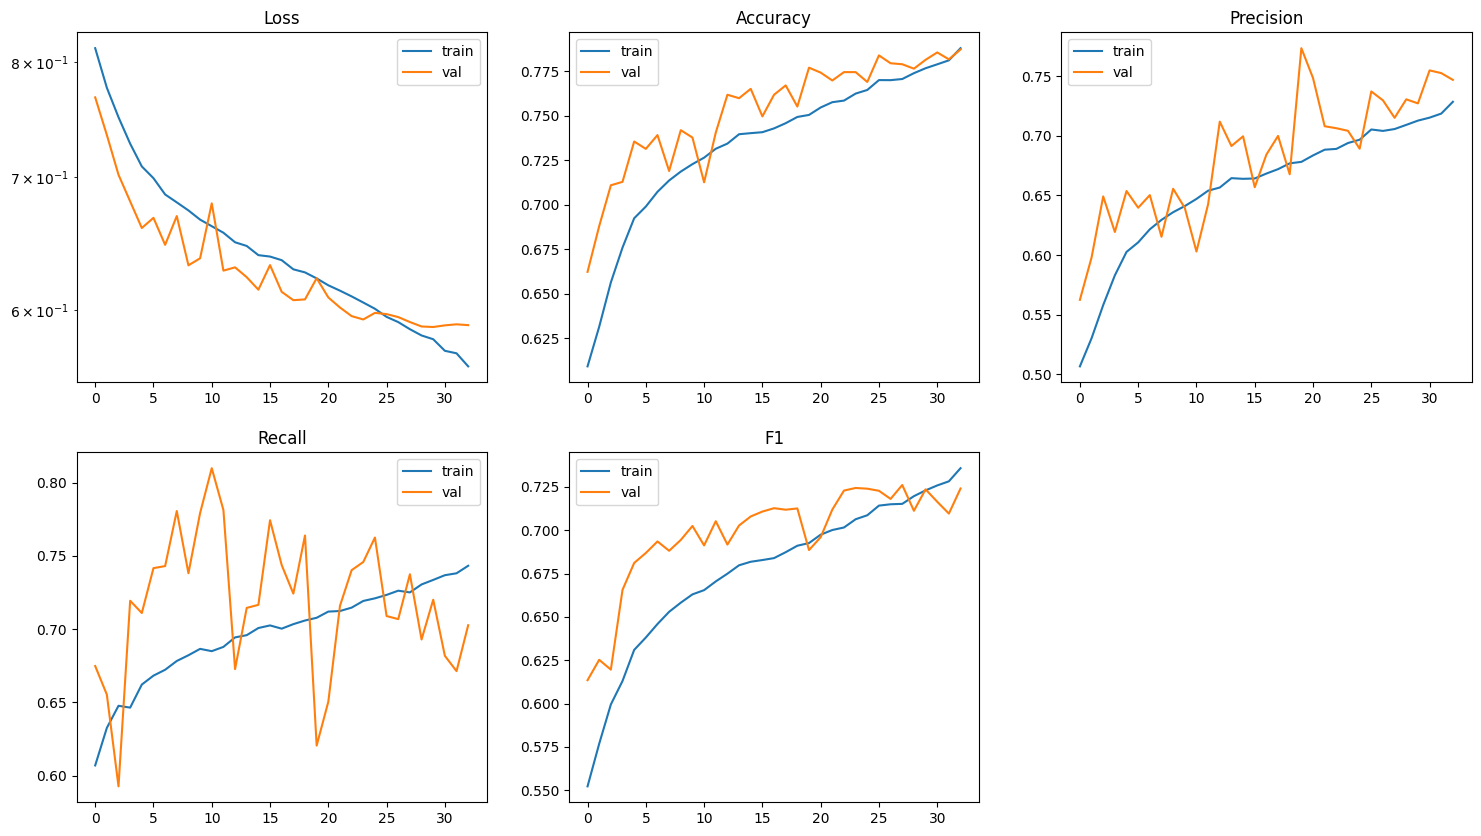


Epoch 33 summary:
Loss      | train: 0.5621 | val: 0.5896
Accuracy  | train: 0.7881 | val: 0.7873
Precision | train: 0.7285 | val: 0.7469
Recall    | train: 0.7433 | val: 0.7026
F1        | train: 0.7358 | val: 0.7241


100%|██████████| 113/113 [01:46<00:00,  1.06it/s]


Early stopping triggered! No improvement for 5 epochs.
Training finished.

Final Metrics History:
{'Loss': {'train': [0.8132139855773194, 0.7767220477372299, 0.7505727785693083, 0.7279040216493313, 0.7089200446315095, 0.6993028917496309, 0.6862271737161326, 0.6799478458103012, 0.6736177346358954, 0.6664555688717624, 0.661394175800393, 0.6564091529231937, 0.6491701950433877, 0.6464056940722898, 0.639544002914142, 0.6384994652786782, 0.6358195504983242, 0.6291115993982863, 0.626867374066567, 0.622508226980673, 0.6175507095960553, 0.6137122730113351, 0.6096463358265691, 0.605318102805651, 0.6009450424569406, 0.5953186988079793, 0.5917207989037115, 0.58685807286313, 0.582618202021085, 0.5800685374678619, 0.5723333344732696, 0.5706715065932108, 0.5620855812674131, 0.5605380792870815], 'val': [0.768097460269928, 0.7352908058504087, 0.7020847826404909, 0.680705763597404, 0.6600310274984984, 0.6678422605041909, 0.6472343863111681, 0.6692229691332421, 0.6320409714120679, 0.6372108715297902, 0.

In [11]:
final_metrics = pipeline.run_training(num_epochs=num_epochs)

print("\nFinal Metrics History:")
print(final_metrics)